In [1]:
#purpose is to generate images in the steps below, first collecting some files
'''
Paths and file needs:
*imglams and spitzer_conversions are excel files, right now I have it so you need to put it as same directory as your code (but could later maybe just give it a path to go to - would be smarter)
*paths to images and data in general
'''
#now the steps
'''
1) read in all the data by noting all the paths to given spitzer and hubble images
2) loop through all the data, read it in, convert units
3) cutout all the data as appropriate
3) create a loop or otherwise hardcode going through all the combinations of convolutions of images by hand...
4) regrid all the images
5) de-extinct all the images
6) create apertures as appropriate for all the knots
7) perform relevant analyses: e.g. taking ratio and then finding EDFs, summing up the intensities of each knot for noting and saving
'''

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys



3.8.13


In [2]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''

def im_conv(D, hdu_pix_torad, hdu_dat, lam, kern):
    #gaussian kernel
    if kern == 'gauss':
        #update: usually cannot find wavelength but these headers are well-labeled    
        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv

# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

In [2]:
# path = '../../Montage_results/n2071_headercut/*drz.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
# im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
# im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
# im_names_n2071 = ['../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']
im_names_n2071 = ['../scaling_for_motions/hops361a_160_epoch1_scaled.fits', '../scaling_for_motions/hops361a_160_epoch2_synth_scaled.fits']

print(im_names_n2071)

['../scaling_for_motions/hops361a_160_epoch1_scaled.fits', '../scaling_for_motions/hops361a_160_epoch2_synth_scaled.fits']


In [3]:
hdu_list = [fits.open(i) for i in im_names_n2071]

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
# hdu_fnu_list = []
hdu_lam_list = []
# hdu_flam_list = []
# hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:       
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(np.nan_to_num(hdu_data[0].data)) # * hdu_list[0].header['PHOTFLAM'] * hdu_list[0].header['PHOTBW'])
    hdu_header_list.append(hdu_data[0].header)
    
    count+=1

In [4]:
%matplotlib inline

# Written by AI + internet querying (featuring you.com chatbot)

In [5]:
# set up the image files appropriately (separate step because faster)
image1 = hdu_data_list[0]
image2 = hdu_data_list[1]

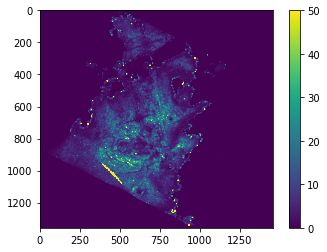

In [46]:
from scipy import signal

# compute the optical flow using the Lucas-Kanade algorithm
# here we use a simple gradient filter to compute image gradients
kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
Ix = signal.convolve2d(image1, kernel, mode='same')
Iy = signal.convolve2d(image1, kernel.T, mode='same')
It = image2 - image1

# initialize the flow vectors to zero
flow_x = np.zeros_like(image1)
flow_y = np.zeros_like(image1)

# loop through each pixel and compute the velocity vector
for i in range(1, image1.shape[0]-1):
    for j in range(1, image1.shape[1]-1):
        A = np.array([[Ix[i, j], Iy[i, j]]])
        b = -1 * np.array([[It[i, j]]])
        v = np.linalg.lstsq(A, b, rcond=None)[0]
        flow_x[i, j] = v[0]
        flow_y[i, j] = v[1]

# do something with the flow vectors, such as computing statistics or plotting

''' 
Comment from AI:
To improve the algorithm, you can try using a different optical flow algorithm or adjusting the parameters of the current algorithm, 
such as the window size or the maximum number of iterations. 
Another approach you could consider is using a different method to track the blobs, such as template matching or feature detection. 
It's also possible that the movement of the blobs is simply too chaotic or unpredictable to track accurately using any algorithm.

My Notes:
Takes about 1 minute to run
'''

plt.imshow(np.sqrt(flow_x**2 + flow_y**2)[::-1], vmin=0, vmax=50)
plt.colorbar()


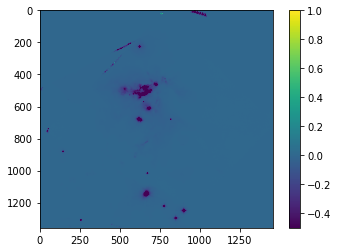

In [53]:
from scipy.ndimage import shift
from scipy.optimize import brute

def diff_shift(shift_amt, image1, image2):
    '''Calculate the difference between two images after shifting one by a certain amount'''
    shifted_image = shift(image2, shift_amt)
    return np.sum((image1 - shifted_image) ** 2)

def optimize_shift(image1, image2):
    '''Use brute force optimization to find the optimal shift for aligning two images'''
    search_range = ((-10, 10), (-10, 10)) # the range of values to search over
    opt_result = brute(diff_shift, search_range, args=(image1, image2), full_output=True, finish=None)
    return opt_result[0]

# example usage
shift_amount = optimize_shift(image1, image2)
aligned_image2 = shift(image2, shift_amount)

plt.imshow(image1 - aligned_image2, vmin=-0.5, vmax=1)
plt.colorbar()

C:\Users\arubi\AppData\Local\Temp\ipykernel_30800\1572328189.py:53: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_expand`. It will be removed in version 1.0. Please use `channel_axis` instead.
  d = skimage.transform.pyramid_expand(d, multichannel=True)


Text(0.5, 1.0, 'displ pix -> speed field')

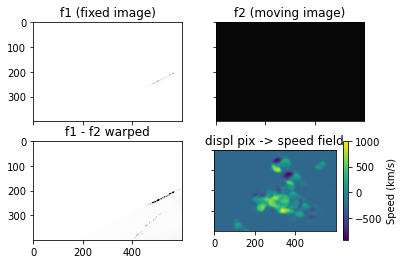

In [57]:
#testing https://github.com/ericPrince/optical-flow
from optical_flow import flow_iterative
import skimage.io
import skimage.transform
from functools import partial

# certainties for images - certainty is decreased for pixels near the edge
# of the image, as recommended by Farneback
c1 = np.minimum(
    1, 1 / 5 * np.minimum(np.arange(image1.shape[0])[:, None], np.arange(image1.shape[1]))
)
c1 = np.minimum(
    c1,
    1
    / 5
    * np.minimum(
        image1.shape[0] - 1 - np.arange(image1.shape[0])[:, None],
        image1.shape[1] - 1 - np.arange(image1.shape[1]),
    ),
)
c2 = c1

n_pyr = 6

# version using no regularization model
opts = dict(
    sigma=5.0,
    sigma_flow=5.0,
    num_iter=4,
    model="constant",
    mu=None,
)

# optical flow field
d = None

# calculate optical flow using pyramids
# note: reversed(...) because we start with the smallest pyramid
for pyr1, pyr2, c1_, c2_ in reversed(
    list(
        zip(
            *list(
                map(
                    partial(skimage.transform.pyramid_gaussian, max_layer=n_pyr),
                    [image1, image2, c1, c2],
                )
            )
        )
    )
):
    if d is not None:
        # TODO: account for shapes not quite matching
        d = skimage.transform.pyramid_expand(d, multichannel=True)
        d = d[: pyr1.shape[0], : pyr2.shape[1]]

    d = flow_iterative(pyr1, pyr2, c1=c1_, c2=c2_, d=d, **opts)

xw = d + np.moveaxis(np.indices(image1.shape), 0, -1)

# warped frame
image2_w = skimage.transform.warp(image2, np.moveaxis(xw, -1, 0), cval=np.nan)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)

p = 0.1  # percentile of histogram edges to chop off
vmin, vmax = np.nanpercentile(image1 - image2_w, [p, 100 - p])
cmap = "gray"

axes[0, 0].imshow(image1, cmap=cmap)
axes[0, 0].set_title("f1 (fixed image)")
axes[0, 1].imshow(image2, cmap=cmap)
axes[0, 1].set_title("f2 (moving image)")
axes[1, 0].imshow(image1 - image2_w, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1, 0].set_title("f1 - f2 warped")
im = axes[1, 1].imshow(d[:,:,0][::-1][600:1000, 300:900] * 22) # in km/s
plt.colorbar(im, label='Speed (km/s)')
axes[1, 1].set_title("displ pix -> speed field")



This code uses optical flow
https://scikit-image.org/docs/stable/auto_examples/registration/plot_opticalflow.html#sphx-glr-auto-examples-registration-plot-opticalflow-py

-Then other motion tracking (priorities in bold): openpiv, trackpy -if I get good thresholding, skimage skeletonize(+segmentation maps at diff sigma), skimage SIFT and BRIEF feature detection, and -Active Contours 

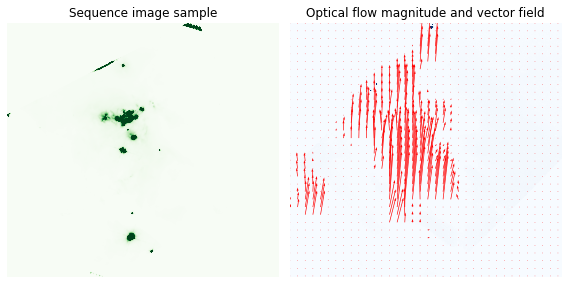

In [15]:
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

# --- Compute the optical flow
v, u = optical_flow_ilk(hdu_data_list[0], hdu_data_list[1], radius=50)
# v, u = optical_flow_tvl1(hdu_data_list[0], hdu_data_list[1], attachment=1, tightness=0.01, num_warp=1, num_iter=5, tol=1e-10)

# --- Compute flow magnitude
norm = np.sqrt(u ** 2 + v ** 2)


# --- Display
from astropy.visualization import ZScaleInterval, ImageNormalize, PercentileInterval
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

# --- Sequence image sample
image0 = hdu_data_list[0]
image1 = hdu_data_list[1]

interval = PercentileInterval(99)
data_interval = interval.get_limits(image0)
norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])

ax0.imshow(image0 , norm=norm, cmap='Greens_r')
ax0.set_title("Sequence image sample")
ax0.set_axis_off()

# --- Quiver plot arguments

nvec = 35  # Number of vectors to be displayed along each image dimension
nl, nc = image0.shape
step = max(nl//nvec, nc//nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u_ = u[::step, ::step]
v_ = v[::step, ::step]


interval = PercentileInterval(99)
data_interval = interval.get_limits(image0)
norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])

ax1.imshow(image1 , norm=norm, cmap='Blues_r')
ax1.quiver(x, y, u_, v_, color='r', units='dots',
           angles='xy', scale_units='xy', lw=3)
ax1.set_title("Optical flow magnitude and vector field")
ax1.set_axis_off()
fig.tight_layout()

plt.show()

Let's try to threshold

c:\Users\arubi\anaconda3\lib\site-packages\skimage\filters\thresholding.py:370: RuntimeWarning: invalid value encountered in true_divide
  mean1 = np.cumsum(counts * bin_centers) / weight1
c:\Users\arubi\anaconda3\lib\site-packages\skimage\filters\thresholding.py:371: RuntimeWarning: invalid value encountered in true_divide
  mean2 = (np.cumsum((counts * bin_centers)[::-1]) / weight2[::-1])[::-1]


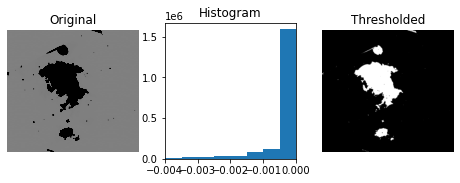

In [66]:
from skimage.filters import threshold_otsu, threshold_mean, threshold_local

thresh = threshold_otsu(hist=(hdu_data_list[0]).ravel(), nbins=2000) #1000 for 361-c
# binary_epoch1 = hdu_data_list[0] < 0.00001 #if doing 361-c
binary_epoch1 = hdu_data_list[0] < -2e-3 #if doing 361-a

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(hdu_data_list[0] - binary_epoch1, cmap=plt.cm.gray, vmin=-0.05, vmax=0.05)
ax[0].set_title('Original')
ax[0].axis('off')

hist = ax[1].hist(hdu_data_list[0].ravel(), bins=2000) #1000 for 361-c, along with norm=norm and range=(data_interval[0], data_interval[1])
ax[1].set_title('Histogram')
ax[1].set_xlim(-4e-3, 0.0) #1e-4 for 361-c
# ax[1].axvline(thresh, color='r')

#thresholding
ax[2].imshow(binary_epoch1, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

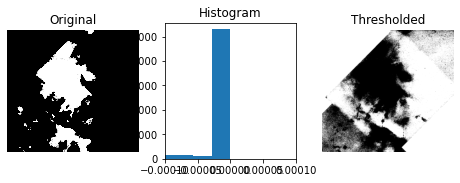

In [67]:
from skimage.filters import threshold_otsu, threshold_mean, threshold_local

thresh = threshold_otsu(hist=(hdu_data_list[1]).ravel(), nbins=1000)
binary_epoch2 = hdu_data_list[1] < 0.000001

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(hdu_data_list[1] - binary_epoch2, norm=norm, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

hist = ax[1].hist(hdu_data_list[1].ravel(), range=(data_interval[0], data_interval[1]), bins=1000)
ax[1].set_title('Histogram')
ax[1].set_xlim(-1e-4, 0.0001)
# ax[1].axvline(thresh, color='r')

#thresholding
ax[2].imshow(binary_epoch2, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

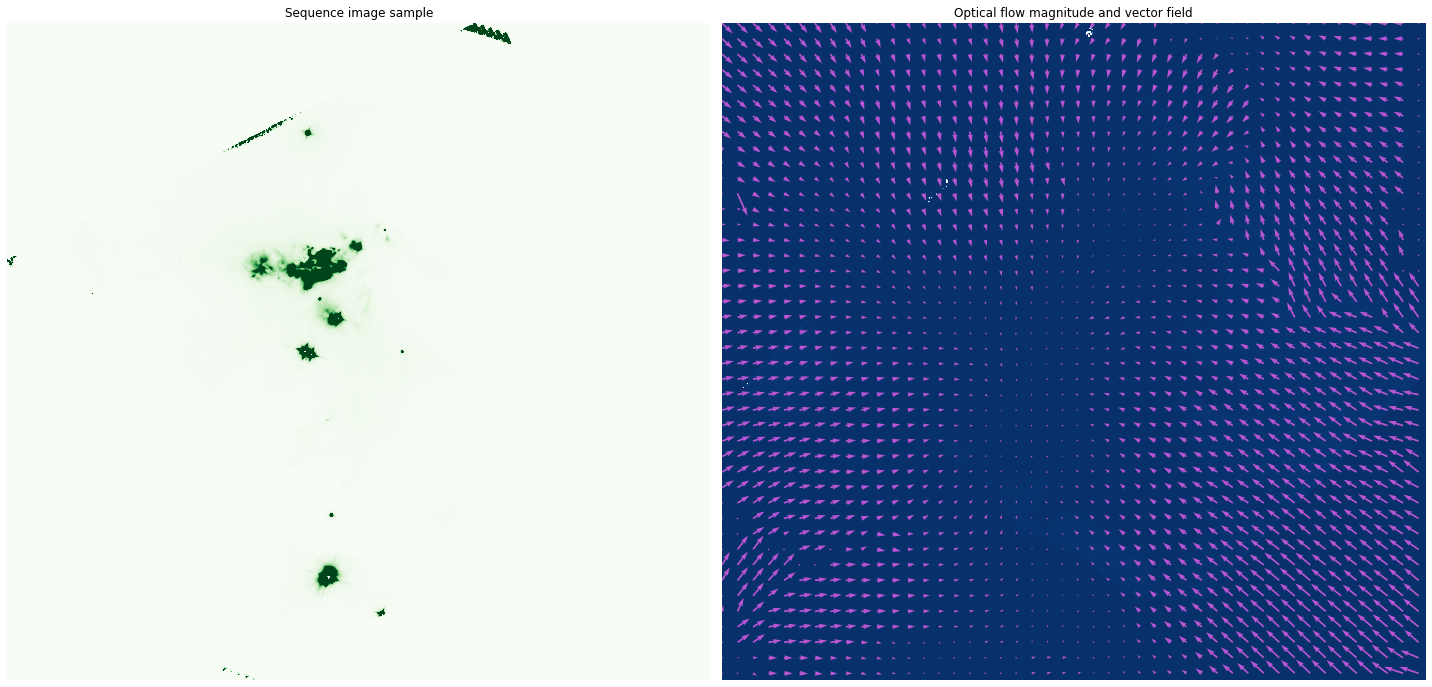

In [68]:
multiple = 15

from skimage.registration import optical_flow_tvl1, optical_flow_ilk

# --- Compute the optical flow
v, u = optical_flow_ilk(hdu_data_list[0] - binary_epoch2, hdu_data_list[1] - binary_epoch1, radius=2 * multiple)
# v, u = optical_flow_tvl1(hdu_data_list[0] - binary_epoch2, hdu_data_list[1] - binary_epoch1, \
#                          attachment=1, tightness=0.01, num_warp=1, num_iter=10, tol=1e-10)

# --- Compute flow magnitude
norm = np.sqrt(u ** 2 + v ** 2)


# --- Display
from astropy.visualization import ZScaleInterval, ImageNormalize, PercentileInterval
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 20))

# --- Sequence image sample

interval = PercentileInterval(99)
data_interval = interval.get_limits(image0)
norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])

ax0.imshow(image0 , norm=norm, cmap='Greens_r')
ax0.set_title("Sequence image sample")
ax0.set_axis_off()

# --- Quiver plot arguments

nvec = 3 * multiple  # Number of vectors to be displayed along each image dimension
nl, nc = image0.shape
step = max(nl//nvec, nc//nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u_ = u[::step, ::step]
v_ = v[::step, ::step]


interval = PercentileInterval(99)
data_interval = interval.get_limits(image0)
norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])

ax1.imshow(image1 , norm=norm, cmap='Blues')
ax1.quiver(x, y, u_, v_, color='mediumorchid', units='dots',
           angles='xy', scale_units='xy', lw=5)
ax1.set_title("Optical flow magnitude and vector field")
ax1.set_axis_off()
fig.tight_layout()

plt.show()

# The Horn Schunk Method
Taken from https://github.com/scivision/pyoptflow/blob/4485da929c5567470d821c3f2a23e3bccc7f768e/src/pyoptflow/hornschunck.py (should give full credits!!)

In [69]:
import numpy as np
from scipy.signal import convolve2d

HSKERN = np.array(
    [[1 / 12, 1 / 6, 1 / 12], [1 / 6, 0, 1 / 6], [1 / 12, 1 / 6, 1 / 12]], float
)

kernelX = np.array([[-1, 1], [-1, 1]]) * 0.25  # kernel for computing d/dx

kernelY = np.array([[-1, -1], [1, 1]]) * 0.25  # kernel for computing d/dy

kernelT = np.ones((2, 2)) * 0.25


def HornSchunck(im1, im2,
    alpha: float = 0.001,
    Niter: int = 8):
    """

    Parameters
    ----------

    im1: numpy.ndarray
        image at t=0
    im2: numpy.ndarray
        image at t=1
    alpha: float
        regularization constant
    Niter: int
        number of iteration
    """
    im1 = im1.astype(np.float32)
    im2 = im2.astype(np.float32)

    # set up initial velocities
    uInitial = np.zeros([im1.shape[0], im1.shape[1]], dtype=np.float32)
    vInitial = np.zeros([im1.shape[0], im1.shape[1]], dtype=np.float32)

    # Set initial value for the flow vectors
    U = uInitial
    V = vInitial

    # Estimate derivatives
    [fx, fy, ft] = computeDerivatives(im1, im2)

    # Iteration to reduce error
    for _ in range(Niter):
        # %% Compute local averages of the flow vectors
        uAvg = convolve2d(U, HSKERN, "same")
        vAvg = convolve2d(V, HSKERN, "same")
        # %% common part of update step
        der = (fx * uAvg + fy * vAvg + ft) / (alpha ** 2 + fx ** 2 + fy ** 2)
        # %% iterative step
        U = uAvg - fx * der
        V = vAvg - fy * der

    return U, V


def computeDerivatives(im1, im2):

    fx = convolve2d(im1, kernelX, "same") + convolve2d(im2, kernelX, "same")
    fy = convolve2d(im1, kernelY, "same") + convolve2d(im2, kernelY, "same")

    # ft = im2 - im1
    ft = convolve2d(im1, kernelT, "same") + convolve2d(im2, -kernelT, "same")

    return [fx, fy, ft]

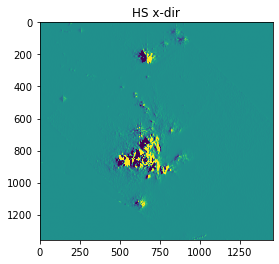

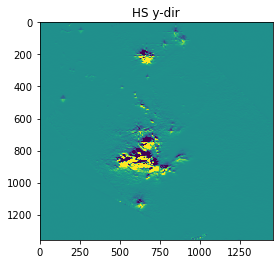

C:\Users\arubi\AppData\Local\Temp\ipykernel_21392\1583306275.py:17: RuntimeWarning: divide by zero encountered in true_divide
  flow_angles = np.arctan(hs_arr[0] / hs_arr[1]) * 180/np.pi
C:\Users\arubi\AppData\Local\Temp\ipykernel_21392\1583306275.py:17: RuntimeWarning: invalid value encountered in true_divide
  flow_angles = np.arctan(hs_arr[0] / hs_arr[1]) * 180/np.pi


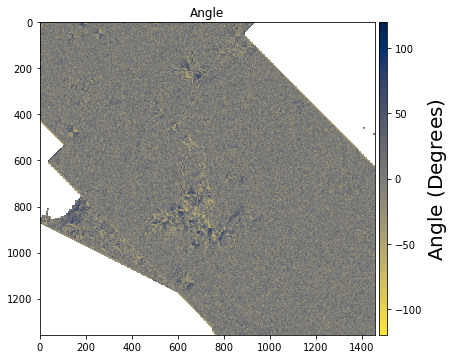

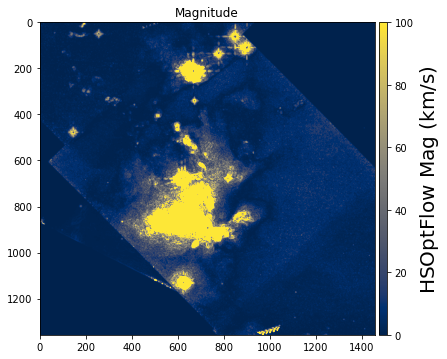

In [77]:
#for hops 361-c
# hs_arr = HornSchunck(np.flip(1e5*hdu_data_list[0] - binary_epoch1, axis=1),
#                      np.flip( 1e5*hdu_data_list[1] - binary_epoch2, axis=1))

#for hops 361-a
hs_arr = HornSchunck(np.flip(hdu_data_list[0], axis=0), np.flip( hdu_data_list[1], axis=0))

plt.title('HS x-dir')
plt.imshow(hs_arr[0], vmin=-1e1, vmax=1e1) #x-direction
plt.show()
plt.title('HS y-dir')
plt.imshow(hs_arr[1], vmin=-1e1, vmax=1e1) #y-direction
plt.show()

#angle
fig, ax = plt.subplots(figsize=(6, 6))
flow_angles = np.arctan(hs_arr[0] / hs_arr[1]) * 180/np.pi
im = ax.imshow(flow_angles, vmin=-120, vmax=120, cmap='cividis_r')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Angle~(Degrees)$', size=20)
ax.set_title('Angle')
plt.show()

#magnitude
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Magnitude')
interesting_flow = 22 * 500. * np.sqrt(hs_arr[1]**2. + hs_arr[0]**2.) / np.max( np.sqrt(hs_arr[1]**2. + hs_arr[0]**2.))
im = ax.imshow(interesting_flow, vmin=0, vmax=100, cmap='cividis')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm HSOptFlow~Mag~(km/s)$', size=20)
plt.show()

In [78]:
fits_saver(np.flip(interesting_flow, axis=0), hdu_header_list[0], '361a_HS_mag_speed.fits', '')
fits_saver(np.flip(flow_angles, axis=0), hdu_header_list[0], '361a_HS_angles.fits', '')

'361a_HS_angles.fits'

# next trying background subtraction, segmentation...

In [12]:
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from astropy.visualization import simple_norm

bkg_estimator = MedianBackground()
bkg_list = []
data_bkg_subtracted = []
threshold_list = []
nsig_list = [2, 1] #IMPORTANT, should change this...

for i in range(len(hdu_data_list)):
    bkg = Background2D(hdu_data_list[i], (25, 25), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    bkg_list.append(bkg)
#     threshold_list.append(2. * bkg.background_rms )  # above the background
    threshold_list = detect_threshold(hdu_data_list[i], nsigma=nsig_list[i])

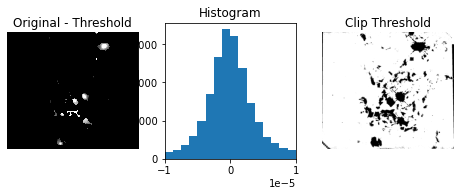

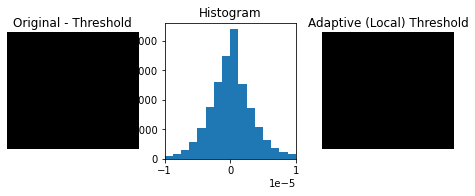

In [13]:
from skimage.filters import threshold_otsu, threshold_mean, threshold_local

thresh = threshold_otsu(hist=(hdu_data_list[0]- bkg_list[0].background).ravel(), nbins=1000)
binary_epoch1 = (hdu_data_list[0]- bkg_list[0].background) < 0.00001
block_size = 35
local_thresh1 = threshold_local(hdu_data_list[0]- bkg_list[0].background, block_size, offset=10)
binary_adaptive1 = (hdu_data_list[0]- bkg_list[0].background) > local_thresh1

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(hdu_data_list[0] - binary_epoch1, norm=norm, cmap=plt.cm.gray)
ax[0].set_title('Original - Threshold')
ax[0].axis('off')

hist = ax[1].hist((hdu_data_list[0]- bkg_list[0].background).ravel(), range=(data_interval[0], data_interval[1]), bins=1000)
ax[1].set_title('Histogram')
ax[1].set_xlim(-1e-5, 1e-5)
# ax[1].axvline(thresh, color='r')

#thresholding
ax[2].imshow(binary_epoch1, cmap=plt.cm.gray)
ax[2].set_title('Clip Threshold')
ax[2].axis('off')

plt.show()

from skimage.filters import threshold_otsu, threshold_mean, threshold_local

thresh = threshold_otsu(hist=((hdu_data_list[1]- bkg_list[1].background)).ravel(), nbins=1000)
binary_epoch2 = (hdu_data_list[1]- bkg_list[1].background) < 0.000001
block_size = 35
local_thresh2 = threshold_local(hdu_data_list[1]- bkg_list[1].background, block_size, offset=10)
binary_adaptive2 = (hdu_data_list[1]- bkg_list[1].background) > local_thresh2

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(hdu_data_list[1] - binary_adaptive2, norm=norm, cmap=plt.cm.gray)
ax[0].set_title('Original - Threshold')
ax[0].axis('off')

hist = ax[1].hist((hdu_data_list[1]- bkg_list[1].background).ravel(), range=(data_interval[0], data_interval[1]), bins=1000)
ax[1].set_title('Histogram')
ax[1].set_xlim(-1e-5, 1e-5)
# ax[1].axvline(thresh, color='r')

#thresholding
ax[2].imshow(binary_adaptive2, cmap=plt.cm.gray)
ax[2].set_title('Adaptive (Local) Threshold')
ax[2].axis('off')

plt.show()

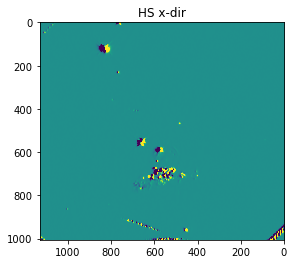

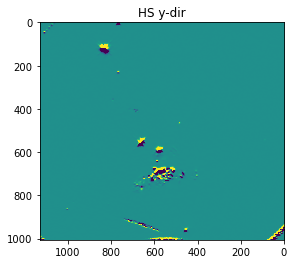

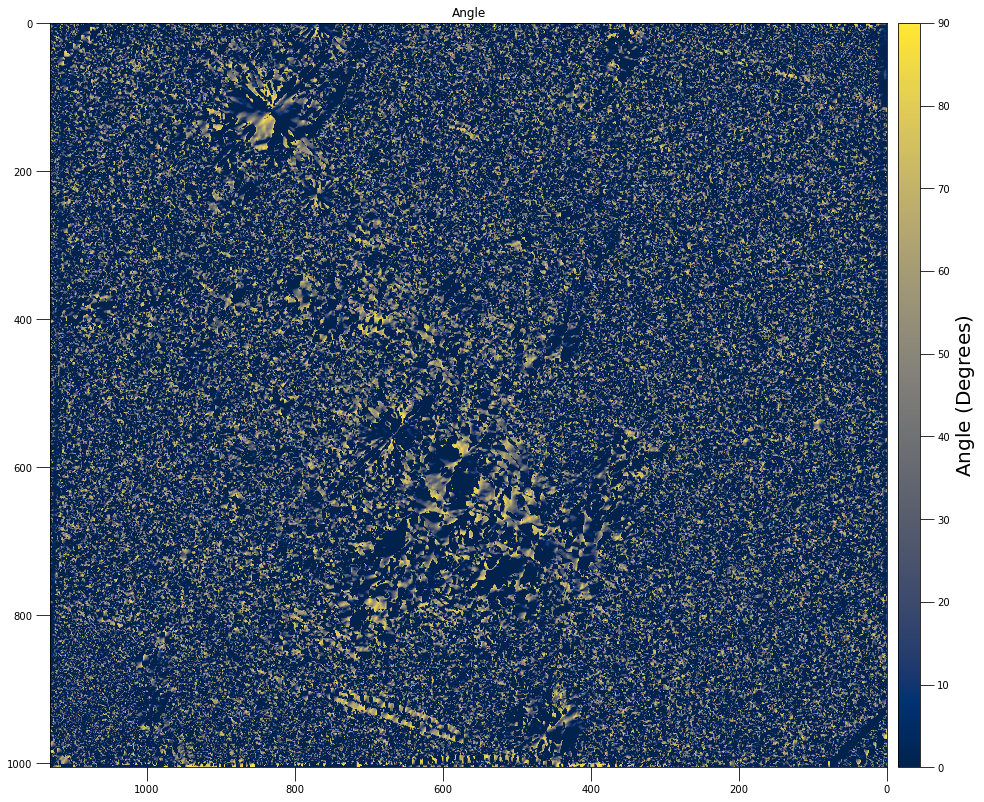

292.9483662881479
109.71824202227363
68.09840765158143
48.9523004511654
1129.5010539406142
185.65115860865873
92.32903918123746
397.28145991162717
19.947245638886947
10.91069212227738


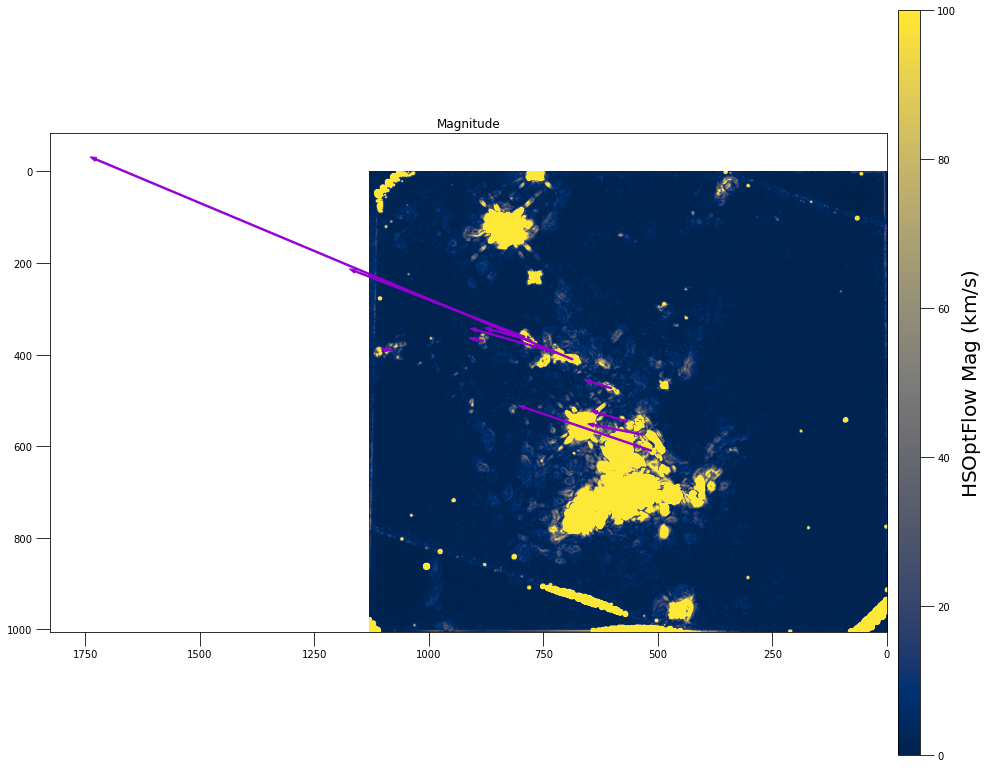

In [14]:
# hs_arr = HornSchunck(np.flip(hdu_data_list[0] - bkg_list[0].background - binary_adaptive1, axis=1),
#                      np.flip( hdu_data_list[1] - bkg_list[1].background - binary_adaptive2, axis=1))
hs_arr = HornSchunck((hdu_data_list[0] - bkg_list[0].background - binary_adaptive1),
                     ( hdu_data_list[1] - bkg_list[1].background - binary_adaptive2))

plt.title('HS x-dir')
plt.imshow(hs_arr[0], vmin=-1e-1, vmax=1e-1) #x-direction
plt.gca().invert_xaxis() #done because it's nicer with declination increasing
plt.show()
plt.title('HS y-dir')
plt.imshow(hs_arr[1], vmin=-1e-1, vmax=1e-1) #y-direction
plt.gca().invert_xaxis() #done because it's nicer with declination increasing
plt.show()


#minor formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14


#angle
fig, ax = plt.subplots(figsize=(15, 15))
flow_angles = np.arctan(hs_arr[1] / hs_arr[0]) * 180/np.pi
im = ax.imshow(flow_angles, vmin=0, vmax=90, cmap='cividis')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Angle~(Degrees)$', size=20)
ax.set_title('Angle')
ax.invert_xaxis() #done because it's nicer with declination increasing
plt.show()

#magnitude
n2071_dist = 1.234e16  #400 pc to km
pix_size = 0.12825 #for hst
time = 3.471e+8 #10 yrs to secs

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title('Magnitude')
interesting_flow = 13.078*22/146.69543920232238 * 23/14 *20*100.*np.sqrt(hs_arr[1]**2. + hs_arr[0]**2.)*pix_size* n2071_dist/206265 / time
im = ax.imshow((interesting_flow), vmin=0, vmax=100, cmap='cividis')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm HSOptFlow~Mag~(km/s)$', size=20)


#overplotting boxes and arrows to show how the method worked
from matplotlib import patches
from photutils.aperture import RectangularAperture
from astropy.coordinates import SkyCoord, FK5
from astropy.wcs.utils import skycoord_to_pixel
from astropy import units as u

# f = open('moving_blobs.reg', 'r')
f = open('361c_extraknots.reg', 'r')
file_output = []
#looping through file 
for line in f:
    file_output.append(line)
f.close()
#fix file contents
#contents are ra, dec, width, height, rotation
file_output = [i[4:-2] for i in file_output[3:]]

count = 0
im_type = ['f160w_Epoch1_reg']
hst_pixsize = 0.12825 #arcsec #known pixel size

for reg_num, region_params in enumerate(file_output):
    try:
        #extracting info from files
        split_params = region_params.split(',')
        ra = split_params[0].split(':')
        ra = ra[0]+'h' + ra[1]+'m' + ra[2]+'s'
        dec = split_params[1].split(':')
        dec = dec[0]+'d' + dec[1]+'m' + dec[2]+'s'  
        position = SkyCoord(ra+' '+dec, frame=FK5)
        width = np.abs(float(split_params[2][:-1])/hst_pixsize)
        height = np.abs(float(split_params[3][:-1])/hst_pixsize)
        rotation = float(split_params[4])

        #converting pixel coordinates
        x_pix = skycoord_to_pixel(position, wcs=WCS(hdu_header_list[0]))[0]
        y_pix = skycoord_to_pixel(position, wcs=WCS(hdu_header_list[0]))[1]

        #finding average values for some sample regions
        aperture = RectangularAperture([x_pix, y_pix], width, height, theta=rotation)
        aper_mask = aperture.to_mask()
        aper_cutout_mag = aper_mask.cutout(interesting_flow)
        mag = np.mean(aper_cutout_mag.data)

        aper_cutout_angle = aper_mask.cutout(flow_angles)
        angle = np.mean(aper_cutout_angle.data) * np.pi / 180.

        #plotting
        plt.plot(y_pix-height, x_pix-width, color='white')
        ax.arrow(x_pix, y_pix, mag*np.cos(-angle+270), mag*np.sin(-angle+270.), width=3., color='darkviolet')

        print(mag)
    except Exception as e:
        print(e)

ax.invert_xaxis() #done because it's nicer with declination increasing
plt.show()

In [15]:
fits_saver(np.flip(interesting_flow, axis=1), hdu_header_list[0], 'HS_mag_speed.fits', '')
fits_saver(np.flip(flow_angles, axis=1), hdu_header_list[0], 'HS_angles.fits', '')

'HS_angles.fits'

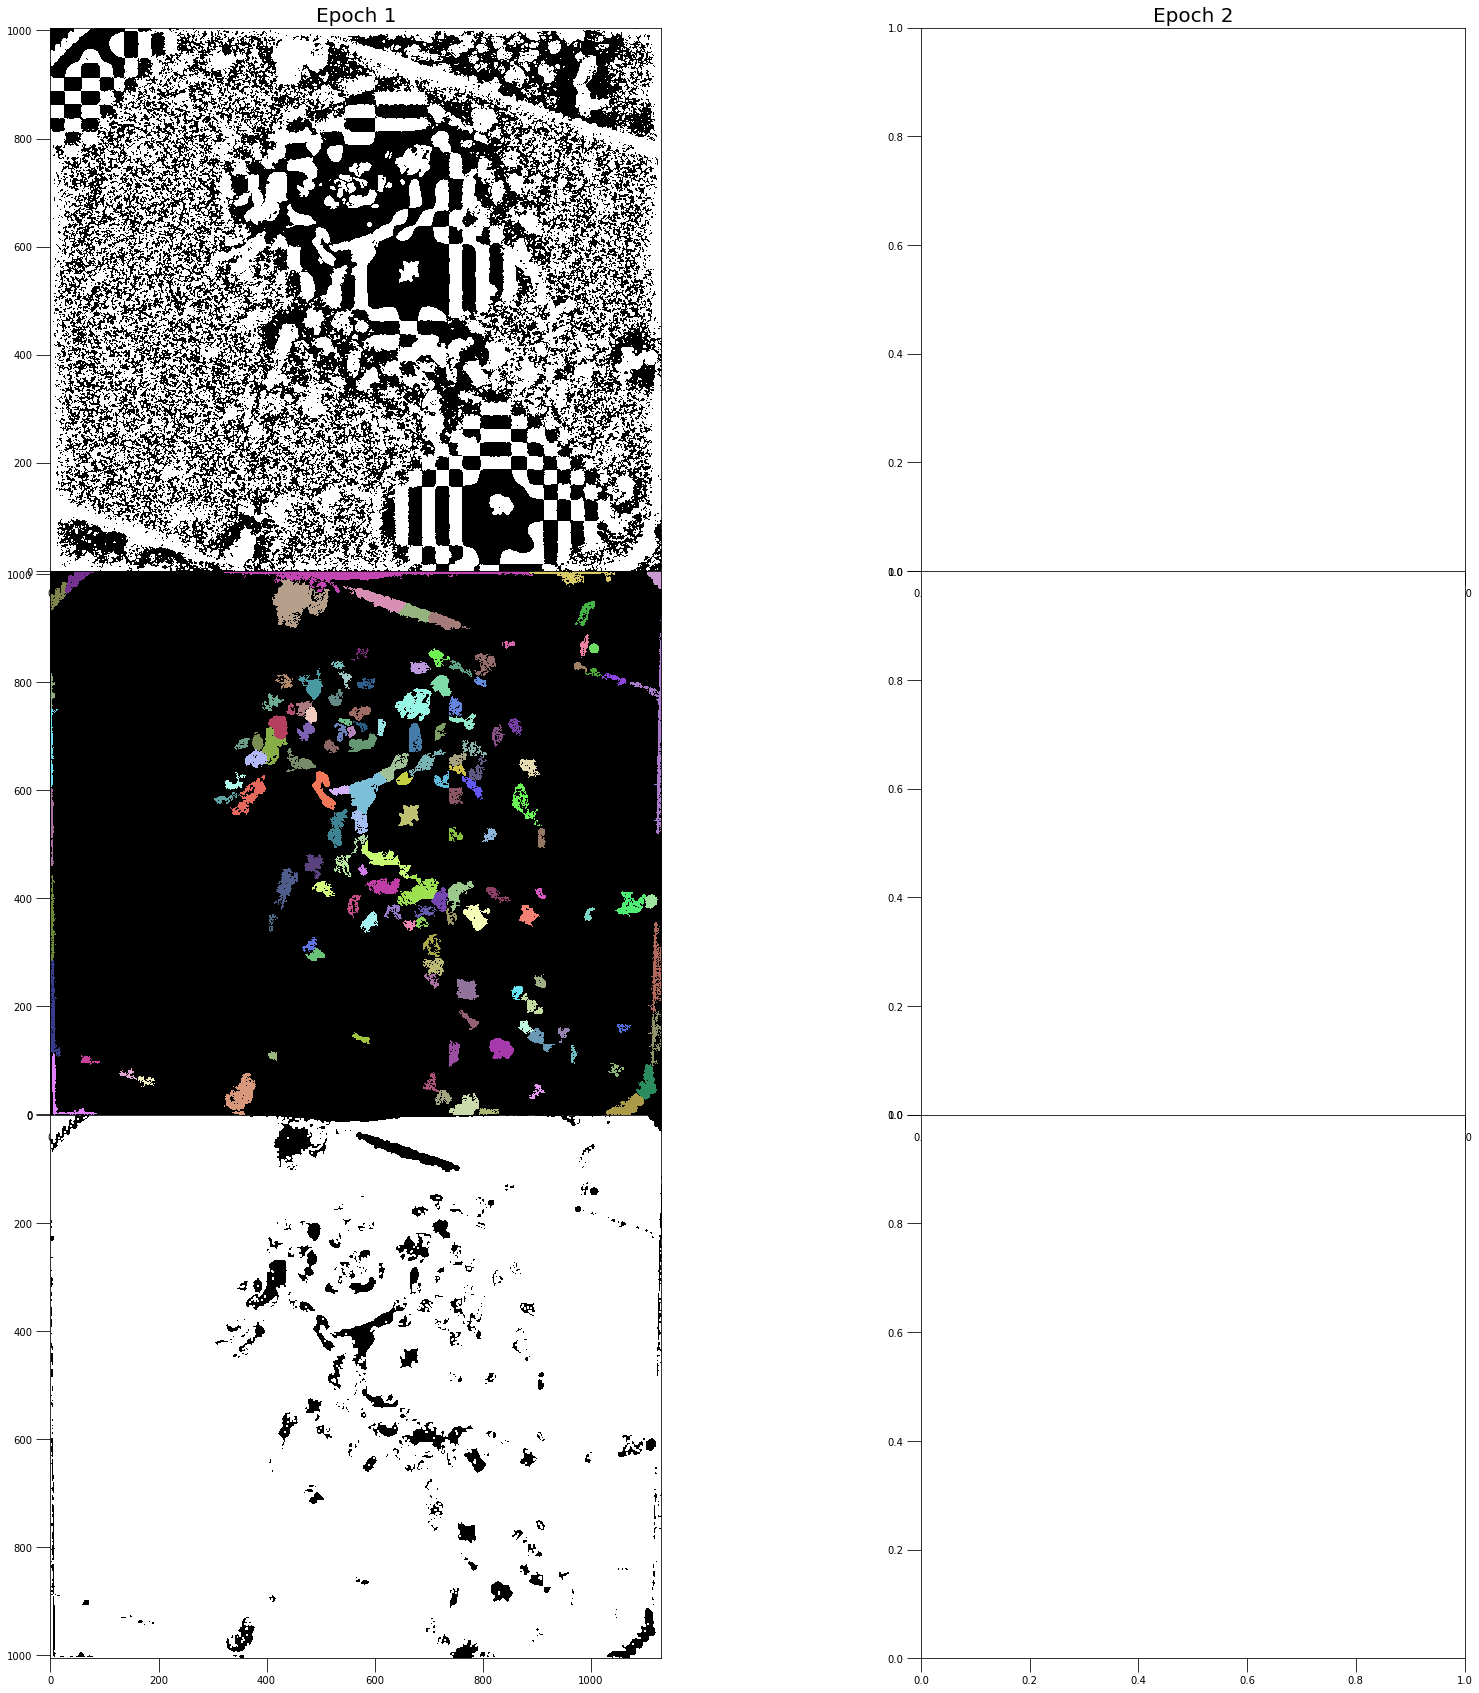

In [16]:
#trying a segmentaiton map
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from astropy.visualization import simple_norm

#this set of cells shows how to apply our procedure to an entire large mosaic image
#first step is background subtraction, thresholding
#I've found better to use no background subtracting, but the option is there if you like

#please see https://photutils.readthedocs.io/en/stable/segmentation.html for references and documentation
#the idea is to use the photutils package and/or segmentation maps to distinguish a bright source from background or noise


bkg_estimator = MedianBackground()
bkg_list = []
data_bkg_subtracted = []
threshold_list = []
nsig_list = [2] #IMPORTANT, should change this...

for i in range(1):
    bkg = Background2D(interesting_flow, (25, 25), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    bkg_list.append(bkg)
#     threshold_list.append(2. * bkg.background_rms )  # above the background
    threshold_list = detect_threshold(interesting_flow, nsigma=nsig_list[i])
    data_bkg_subtracted.append( interesting_flow - bkg.background ) # subtract the background
    
    
#next we apply segmentation maps
npixels_list = [200]
segm_deblend_list = []

for i in range(len(data_bkg_subtracted)):
    data = data_bkg_subtracted[i]
    threshold = threshold_list[i]
    npixels = npixels_list[i]
    segm = detect_sources(data, threshold, npixels=npixels)
    segm_deblend_list.append( deblend_sources(data, segm, npixels=npixels, nlevels=64, contrast=0.0001, progress_bar=False) )
    

#finally we plot the image, the segments, and also show you can automatically produce naive apertures
fig, ax = plt.subplots(3, 2, figsize=(30,30))
ax[0,0].set_title('Epoch 1', fontsize=20)
ax[0,1].set_title('Epoch 2', fontsize=20)

for i in range(1):
    #plotting the thresholded data
    norm = simple_norm(data_bkg_subtracted[i], 'sqrt')
    ax[0,i].imshow(data_bkg_subtracted[i], origin='lower', cmap='Greys_r', vmin=0, vmax=0.0001)
    
    #plotting the associated segmentation map
    cmap = segm_deblend_list[i].make_cmap(seed=123)
    ax[1,i].imshow(segm_deblend_list[i], origin='lower', cmap=cmap, interpolation='nearest')
    
    
#looping through segments
for i in range(1):
    for j in segm_deblend_list[i].labels:
        segm_nparr = np.array(segm_deblend_list[i])  #this is the list of segments 
        data_masked = np.ma.masked_array(data_bkg_subtracted[i], mask=segm_nparr) #masking the data using segm_nparr
        mask=np.ma.getmask(data_masked) #we need to invert the mask, so we grab it
        data_masked = np.ma.masked_array(data_bkg_subtracted[i], mask=~mask) #then we invert it
        im = ax[2,i].imshow(np.flip(data_masked, axis=0), vmin=0, vmax=0.0001, cmap='Greys')#, cmap=cmap_list[i])

        
for a in ax:
    for b in a:
    #     a.set_xticklabels([])
    #     a.set_yticklabels([])
        b.set_aspect('equal')
fig.subplots_adjust(wspace=0, hspace=0)

# Attempting Lucas-Kanade

In [14]:
#all credits for this code goes to this wordpress site by "Sandipan Dey"=https://sandipanweb.wordpress.com/2018/02/25/implementing-lucas-kanade-optical-flow-algorithm-in-python/
#please visit!

import numpy as np
from scipy import signal
def LucaseKanade(I1g, I2g, window_size, tau=1e-2):
 
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    w = int(window_size/2) # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1g = I1g # normalize pixels
    I2g = I2g # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t
    mode = 'same'
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode)
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode=mode) + \
         signal.convolve2d(I1g, -kernel_t, boundary='symm', mode=mode)
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    # within window window_size * window_size
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            b = np.reshape(It, (It.shape[0],1)) # get b here
            A = np.vstack((Ix, Iy)).T # get A here
            # if threshold τ is larger than the smallest eigenvalue of A'A:
            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
                nu = np.matmul(np.linalg.pinv(A), b) # get velocity here
                u[i,j]=nu[0]
                v[i,j]=nu[1]
 
    return (u,v)

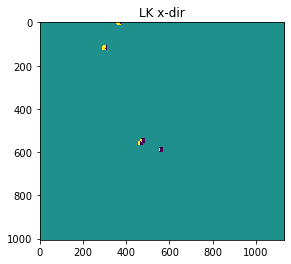

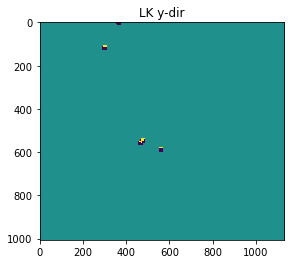

C:\Users\arubi\AppData\Local\Temp\ipykernel_4004\2963970394.py:13: RuntimeWarning: invalid value encountered in divide
  flow_angles = np.arctan(lk_arr[1] / lk_arr[0]) * 180/np.pi


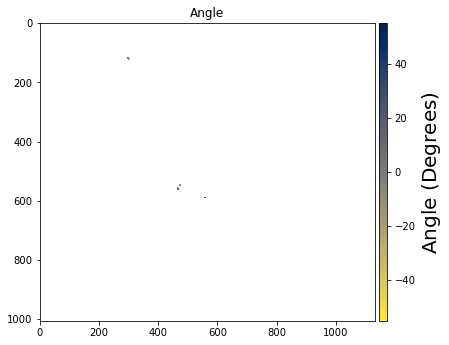

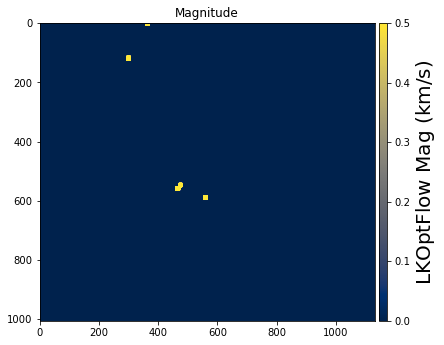

In [17]:
lk_arr = LucaseKanade(np.flip(hdu_data_list[0] - bkg_list[0].background - binary_adaptive1, axis=1),
                     np.flip( hdu_data_list[1] - bkg_list[1].background - binary_adaptive2, axis=1), 10, 1e-1)

plt.title('LK x-dir')
plt.imshow(lk_arr[0], vmin=-1e-16, vmax=1e-16) #x-direction
plt.show()
plt.title('LK y-dir')
plt.imshow(lk_arr[1], vmin=-1e-16, vmax=1e-16) #y-direction
plt.show()

#angle
fig, ax = plt.subplots(figsize=(6, 6))
flow_angles = np.arctan(lk_arr[1] / lk_arr[0]) * 180/np.pi
im = ax.imshow(flow_angles, vmin=-55, vmax=55, cmap='cividis_r')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Angle~(Degrees)$', size=20)
ax.set_title('Angle')
plt.show()

#magnitude
n2071_dist = 1.234e16  #400 pc to km
pix_size = 0.12825 #for hst
time = 3.471e+8 #10 yrs to secs

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Magnitude')
interesting_flow = np.sqrt(lk_arr[1]**2. + lk_arr[0]**2.) * np.max( np.sqrt(lk_arr[1]**2. + lk_arr[0]**2.)) \
                        *pix_size* n2071_dist/206265 / time
im = ax.imshow((interesting_flow), vmin=0, vmax=5e-1, cmap='cividis')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm LKOptFlow~Mag~(km/s)$', size=20)
plt.show()

# Trying OpenCV

In [23]:
#need to change data to a diff range 0...1 or 0...256
im1 = hdu_data_list[0] - bkg_list[0].background - binary_adaptive1
im2 = hdu_data_list[1] - bkg_list[1].background - binary_adaptive2

In [28]:
from skimage.util import img_as_float

im1_norm = img_as_float(im1)
im2_norm = img_as_float(im2)